In [2]:
import numpy as np
import scanpy as sc
import os
import anndata
import matplotlib.pyplot as plt
import scipy
from scipy.stats import wilcoxon
from matplotlib.pyplot import figure
import copy
import json
import gseapy
from gseapy import enrichr

In [3]:

pids=[]
f = open('sids.txt','r')
lines=f.readlines()
for l in lines:
    pids.append(l.strip())

reprefile = 'training_rec/init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'training_rec/init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
init_representatives=[]
for l in lines:
    init_representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
init_cluster_labels=[]
lines=f.readlines()
for l in lines:
    init_cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [4]:
pnum = 28
rnd = int(pnum/4)

reprefile = 'training_rec/eer_representatives_'+str(rnd)+'.txt'    #6000genebackup/
#'eer_representatives_'+str(rnd)+'.txt' #'init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'training_rec/eer_cluster_labels_'+str(rnd)+'.txt'
#'eer_cluster_labels_'+str(rnd)+'.txt' #'init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
representatives=[]
for l in lines:
    representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
cluster_labels=[]
lines=f.readlines()
for l in lines:
    cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [8]:
#pidlist = []
#for i in init_representatives:
#    reppid = []
#    repdata = anndata.read_h5ad('sample_sc/'+pids[i]+'.h5ad')
#    for j in range(repdata.X.shape[0]):
#        reppid.append(pids[i])
#    pidlist = pidlist + reppid
    

In [9]:
#f=open('ref_pids.txt','w')
#for i in pidlist:
#    f.write(i+'\n')
#f.close()

In [5]:
### get highly varialbe bulk
hvmask = np.load('hvmask.npy')
bulkdata = anndata.read_h5ad('bulkdata.h5ad')
hvbulkdata = bulkdata[:,hvmask]
hvgenes = np.array(hvbulkdata.var.index)

In [6]:
gtdata=anndata.read_h5ad('gtdata_final.h5ad')

In [12]:
## get single-cell reference
# get expression matrix
repxs = []
for i in init_representatives:
    repx = ((gtdata[gtdata.obs['sample_ids'] == pids[i]].X))
    repx = np.exp(repx)-1
    repxs.append(repx)
repxs = np.concatenate(repxs,axis=0)
repxs = np.array(repxs)
repxs.max()

7219.874

In [15]:
# get labels
reflabels = []
for i in init_representatives:
    repdata = gtdata[gtdata.obs['sample_ids'] == pids[i]]
    rlbs = repdata.obs['initial_clustering']
    reflabels.append(list(rlbs))
reflabels = np.concatenate(reflabels,axis=0)

# get genes
genelist = list(gtdata.var.index)

In [17]:
hvgenelist=genelist
f=open('hvbulktape4.txt','w')
f.write('GeneSymbol')
for i in range(len(hvgenelist)):
    f.write('\t'+hvgenelist[i])
f.write('\n')
for i in range(hvbulkdata.X.shape[0]):
    f.write(pids[i])
    for j in range(len(hvgenelist)):
        f.write('\t' + str(hvbulkdata.X[i,j]))
    f.write('\n')

f.close()

In [18]:
f=open('hvreftape4.txt','w')

hvrepxs = np.array(repxs)
f.write('GeneSymbol')
hvgenelist = np.array(genelist)
for i in range(len(hvgenelist)):
    f.write('\t'+str(hvgenelist[i]))
f.write('\n')

for i in range(len(reflabels)):
    f.write(reflabels[i])
    for j in range(len(hvgenelist)): 
        f.write('\t'+str(hvrepxs[i,j]))
    f.write('\n')

f.close()

In [10]:
hvmask = np.load('hvmask.npy')


In [9]:
semisdata = anndata.read_h5ad('semisdata_final.h5ad')

In [30]:
semisdata

AnnData object with n_obs × n_vars = 665605 × 6030
    obs: 'status', 'status_collection', 'sampleids', 'repmask', 'IFN_score', 'initial_clustering', 'celltypes', 'states_collection_sum'
    var: 'feature_types'
    uns: 'celltypes_colors', 'celltypes_sizes', 'neighbors', 'paga', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
## load and pca together
import timeit 

t_start = timeit.default_timer()

#representatives = new_representatives#init_representatives  # newrepre
#cluster_labels = new_cluster_labels  #init_cluster_labels #nlabels
status = []
status_collection = []
states_collection_sum = []
worst_status = []
celltypes = []
subtypes = []
gts=[]
semis=[]


pcelltypes = []

celltypes4 = []
semis4=[]
gtpids = []

semi_status_collection =[ ]
semi_states_collection_sum = []
semi_status = []

for i in range(len(pids)):
    pid = pids[i]
    
    adata = anndata.read_h5ad('sample_sc/'+pid+'.h5ad')
    subtype = adata.obs['full_clustering']
    celltype = adata.obs['initial_clustering']
    status.append(adata.obs['Status'])
    status_collection.append(adata.obs['Status_on_day_collection'])
    states_collection_sum.append(list(adata.obs['Status_on_day_collection_summary']))
    worst_status.append(adata.obs['Worst_Clinical_Status'])
    x = adata.X[:,hvmask]
    x = np.array(x.todense())
    x = np.log1p(x)
    #x = sparse.csr_matrix(x)
    gts.append(x) ####### loadiing thresholded gt data
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(x)
        xsem = x
    else:
        
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy') # 6000genebackup/
        xsem = xsem * (xsem>10)  # threshold
        xsem = np.log(xsem+1)  # log1p
        xsem = np.array(xsem)
        semis.append(xsem)
        
    
    initrepre = init_representatives[init_cluster_labels[i]]
    initreprepid = pids[initrepre]
    if initreprepid==pid:
        semis4.append(x)
    else:
        xsem4 = np.load('semidata/fast'+ initreprepid+'_to_'+pid+'.npy') # 6000genebackup/
        xsem4 = xsem4 * (xsem4>10)  # threshold
        xsem4 = np.log(xsem4+1)  # log1p
        xsem4 = np.array(xsem4)
        semis4.append(xsem4)

    celltypes4.append(celltype)
    
    
    ssc = []
    sscs = []
    ss = []
    for j in range(xsem.shape[0]):
        ssc.append(status_collection[-1][0])
        sscs.append(states_collection_sum[-1][0])
        ss.append(status[-1][0])

    semi_status_collection.append(ssc)
    semi_states_collection_sum.append(sscs)
    semi_status.append(ss)
    
    gtpid = []
    for j in range(adata.X.shape[0]):
        gtpid.append(pid)
    gtpids = gtpids + gtpid
    
    bdata = semisdata[semisdata.obs['sampleids'] == pid]
    pcelltype = bdata.obs['celltypes']
    
    pcelltypes.append(pcelltype)
    celltypes.append(celltype)
    subtypes.append(subtype)
    print(i,end=', ')

#X = np.concatenate([np.array(gts),np.array(xsemis)],axis=0)
#pca = PCA(n_components=100)
#X_PCA = pca.fit_transform(X)
#umap_reduc=umap.UMAP()
#X_UMAP = umap_reduc.fit_transform(X_PCA)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 

In [ ]:
# log scale sanity check
for i in range(len(pids)):
    if gts[i].max()>10:
        print(gts[i].max())
    if semis[i].max()>10:
        print(semis[i].max())

In [33]:
import sklearn
from sklearn.svm import LinearSVC

In [ ]:
def deconv(svc,xtest):
    ytest = svc.predict((xtest))
    return list(ytest)

In [112]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
#neigh = NearestNeighbors(n_neighbors=1)
#neigh.fit(samples)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#RandomForestClassifier(max_depth=2, random_state=0)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

st =  timeit.default_timer()

#linearSVM = LinearSVC(tol=1e-5)
#linearSVM = make_pipeline(StandardScaler(),
                    #LinearSVC( random_state=0, tol=1e-5))
#RandomForestClassifier()
#linearSVM = LinearSVC(penalty='l1',loss='squared_hinge',tol=1e-5,C=10,dual=False,max_iter=5000)#,max_iter=5000)    #KNeighborsClassifier(n_neighbors=15)
linearSVM = MLPClassifier(hidden_layer_sizes=(200,)) # LinearSVC()
xtrain=[]
ytrain=[]
for i in (init_representatives):
    #xtrain.append(np.array(xpca4[i]))
    xtrain.append(np.array(gts[i]))
    ytrain.append(np.array(celltypes[i]))
xtrain = np.concatenate(xtrain,axis=0)
ytrain = np.concatenate(ytrain,axis=0)
linearSVM.fit((xtrain),ytrain)
#linearSVM.fit((np.log(x_train+1)), y_train)

ed = timeit.default_timer()
print(str(ed-st))

677.3133289309917


In [13]:
st =  timeit.default_timer()

predictor28 = MLPClassifier(random_state=1) # LinearSVC()
xtrain=[]
ytrain=[]
for i in (representatives):
    #xtrain.append(np.array(xpca4[i]))
    xtrain.append(np.array(gts[i]))
    ytrain.append(np.array(celltypes[i]))
xtrain = np.concatenate(xtrain,axis=0)
ytrain = np.concatenate(ytrain,axis=0)
predictor28.fit((xtrain),ytrain)
#linearSVM.fit((np.log(x_train+1)), y_train)

ed = timeit.default_timer()
print(str(ed-st))

2547.083472092985


In [14]:
st =  timeit.default_timer()

pcelltypes = []
for i in range(len(pids)):
    if i in representatives:
        pcelltypes.append(celltypes[i])
        continue
    pcelltypes.append(list(deconv(predictor28,semis[i])))
    #pcelltypes.append(list(deconv(linearSVM,xpca4[i])))
    
ed = timeit.default_timer()
print(str(ed-st))

5.136265466106124


In [ ]:
totaltypes = np.unique(np.concatenate(celltypes,axis=0))

In [ ]:
def prop(gttypes ,semitypes, totaltypes):
    pgt = np.zeros(totaltypes.shape)
    psemi = np.zeros(totaltypes.shape)
    for i in range(len(totaltypes)):
        pgt[i] += (np.array(gttypes) == totaltypes[i]).sum()
        psemi[i] += (np.array(semitypes) == totaltypes[i]).sum()  ## celltypes2
    numgt=pgt
    numsemi=psemi
    pgt = pgt/pgt.sum()
    psemi = psemi/psemi.sum()
    pcor,pval = scipy.stats.pearsonr(pgt,psemi)
    return pcor,pval,pgt,psemi,numgt,numsemi

In [ ]:
def RMSE(p1,p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    mse = ((p1-p2)**2).mean()
    rmse = mse**0.5
    return rmse

In [ ]:
pcors = []
pgts=[]
psemis=[]
numgts = []
numsemis = []
prmses = []
for i in range(len(pids)):
    if i in representatives:
        pcors.append(1)
        prmses.append(0)
        continue
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],pcelltypes[i],totaltypes)
    pcors.append(pcor)
    pgts.append(pgt)
    psemis.append(psemi)
    numgts.append(numgt.astype('float'))
    numsemis.append(numsemi.astype('float'))
    prmses.append(RMSE(pgt,psemi))

In [ ]:
### naive 
naivecors = []
naivermse = []
for i in range(len(pids)):
    if i in representatives:
        naivecors.append(1)
        naivermse.append(0)
        continue
    rep = representatives[cluster_labels[i]]
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],celltypes[rep],totaltypes)
    naivecors.append(pcor)
    naivermse.append(RMSE(pgt,psemi))

In [ ]:
pids =[]
f = open('sids.txt')
lines = f.readlines()
for l in lines:
    pids.append(l.strip())
f.close()

In [114]:
pcelltypes4 = []
for i in range(len(pids)):
    if i in init_representatives:
        pcelltypes4.append(celltypes[i])
        continue
    pcelltypes4.append(list(deconv(linearSVM,semis4[i])))


In [115]:
pcors4 = []
pgts4=[]
psemis4=[]
numgts4 = []
numsemis4 = []
prmses4 = []
for i in range(len(pids)):
    if i in init_representatives:
        pcors4.append(1)
        prmses4.append(0)
        continue
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes4[i],pcelltypes4[i],totaltypes)
    pcors4.append(pcor)
    pgts4.append(pgt)
    psemis4.append(psemi)
    numgts4.append(numgt.astype('float'))
    numsemis4.append(numsemi.astype('float'))
    prmses4.append(RMSE(pgt,psemi))

In [44]:
### naive 
naivecors4 = []
naivermse4 = []
for i in range(len(pids)):
    if i in init_representatives:
        naivecors4.append(1)
        naivermse4.append(0)
        continue
    rep = init_representatives[init_cluster_labels[i]]
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes4[i],celltypes4[rep],totaltypes)
    naivecors4.append(pcor)
    naivermse4.append(RMSE(pgt,psemi))

In [45]:
gtdata = anndata.read_h5ad('gtdata_final.h5ad')

In [28]:
gtdata = anndata.read_h5ad('gtdata_pids.h5ad')

### extract single-cell reference and bulk data for other deconv tools

In [58]:
## get single-cell reference

# get expression matrix
repxs = []
for i in init_representatives:
    repx = ((gtdata[gtdata.obs['sample_ids'] == pids[i]].X))
    repx = np.exp(repx)-1
    repxs.append(repx)
repxs = np.concatenate(repxs,axis=0)
repxs = np.array(repxs)

In [60]:
# get labels
reflabels = []
for i in init_representatives:
    repdata = gtdata[gtdata.obs['sample_ids'] == pids[i]]
    rlbs = repdata.obs['celltypes']
    reflabels.append(list(rlbs))
reflabels = np.concatenate(reflabels,axis=0)

# get genes
genelist = list(gtdata.var.index)

In [61]:
hvgenelist = genelist
f=open('hvbulktape4.txt','w')
f.write('GeneSymbol')
for i in range(len(hvgenelist)):
    f.write('\t'+hvgenelist[i])
f.write('\n')
for i in range(hvbulkdata.X.shape[0]):
    f.write(pids[i])
    for j in range(len(hvgenelist)):
        f.write('\t' + str(hvbulkdata.X[i,j]))
    f.write('\n')

f.close()



In [64]:

pidlist = []
for i in init_representatives:
    repdata = gtdata[gtdata.obs['sample_ids'] == pids[i]]
    pidlist = pidlist + list(repdata.obs['sample_ids'])
    
f=open('ref_pids.txt','w')
for i in pidlist:
    f.write(i+'\n')
f.close()

In [65]:
hvgenelist = genelist
f=open('hvref.txt','w')

hvrepxs = np.array(repxs)
f.write('GeneSymbol')
for i in range(len(reflabels)):
    f.write('\t'+str(reflabels[i]))
f.write('\n')
hvgenelist = np.array(genelist)
for i in range(len(hvgenelist)):
    f.write(hvgenelist[i])
    for j in range(len(reflabels)):
        f.write('\t'+str(hvrepxs[j,i]))
    f.write('\n')

f.close()

#### end of extracting data

### start loading results and comparison

In [91]:
totaltypes

array(['B_cell', 'CD14', 'CD16', 'CD4', 'CD8', 'DCs', 'HSC',
       'Lymph_prolif', 'MAIT', 'Mono_prolif', 'NK_16hi', 'NK_56hi',
       'Plasmablast', 'Platelets', 'RBC', 'Treg', 'gdT', 'pDC'],
      dtype=object)

In [90]:
tapedf.

,GeneSymbol,B_cell,CD14,CD16,CD4,CD8,DCs,HSC,Lymph_prolif,MAIT,Mono_prolif,NK_16hi,NK_56hi,Plasmablast,Platelets,RBC,Treg,gdT,pDC
0,AP1,0.063458,0.061868,0.057911,0.066683,0.054995,0.088913,0.060740,0.035930,0.050107,0.068122,0.041560,0.052935,0.055728,0.041968,0.072786,0.045102,0.039197,0.041997
1,AP10,0.078264,0.048214,0.056538,0.063544,0.056796,0.084113,0.061663,0.036881,0.056300,0.059744,0.043094,0.050479,0.058003,0.041648,0.070208,0.050181,0.040566,0.043765
2,AP11,0.065156,0.073885,0.068041,0.038464,0.055562,0.099253,0.060061,0.037792,0.046185,0.088765,0.037497,0.049798,0.053819,0.040002,0.069444,0.041359,0.034412,0.040505
3,AP12,0.071812,0.060856,0.055256,0.042783,0.054953,0.088009,0.059574,0.039773,0.053495,0.072340,0.058736,0.058885,0.046540,0.041881,0.071543,0.042335,0.039776,0.041454
4,AP2,0.060713,0.054273,0.060325,0.052415,0.063983,0.086850,0.063467,0.042596,0.049819,0.071387,0.035596,0.052383,0.049606,0.048600,0.072931,0.049808,0.041110,0.044138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,newcastle21v2,0.050830,0.074100,0.065398,0.036115,0.056412,0.101456,0.061461,0.043035,0.047400,0.082315,0.045499,0.056826,0.044336,0.047373,0.069175,0.040168,0.035313,0.042788
120,newcastle49,0.053704,0.075382,0.073338,0.038715,0.051397,0.097310,0.062014,0.041624,0.046630,0.087344,0.035455,0.053599,0.047560,0.045780,0.067026,0.041414,0.035468,0.046242
121,newcastle59,0.054534,0.087127,0.082223,0.034528,0.049796,0.101166,0.058944,0.039253,0.045480,0.088817,0.040544,0.053622,0.044806,0.040778,0.065999,0.037953,0.031723,0.042707
122,newcastle65,0.056432,0.057794,0.064462,0.044029,0.064519,0.091400,0.064497,0.042738,0.049576,0.068437,0.043763,0.053269,0.047011,0.047476,0.071386,0.047571,0.040624,0.045016


In [66]:
import pandas as pd
tapedf = pd.read_csv('tageresult.csv')
ptape = []

for i in range(len(pids)):
    if i in init_representatives:
        ptape.append(1.0)
        continue
    bprp = np.array(tapedf.to_numpy()[:,1:])[i]
    bprp = np.array((list(bprp)))
    ptape.append(bprp)

In [88]:
list(pids) == list(tapedf['GeneSymbol'])

True

In [67]:
tapecor = []
tapermse = []
for i in range(len(pids)):
    if i in init_representatives:
        tapecor.append(1)
        tapermse.append(0)
        continue
    pid = pids[i]
    gttypes = list(gtdata[gtdata.obs['sample_ids']==pid].obs['celltypes'])
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcor,pval = scipy.stats.pearsonr(pgt,ptape[i])
    tapecor.append(pcor)
    tapermse.append(RMSE(pgt,pbis[i]))

In [79]:
sdf = pd.read_csv('scadenresult.csv')
pscaden = []
for i in range(len(pids)):
    if i in representatives:
        pscaden.append(1.0)
        continue
    pid=pids[i]
    #pid = pids[i].replace('-','.')
    bprp = np.array((sdf.to_numpy()[:,1:])[i])
    bprp = np.array((list(bprp)))
    #bprp = bprp[ [0,1,2,3,4,5,6,7,9,10,8]]
    pscaden.append(bprp)

In [89]:
list(pids) == list(sdf['GeneSymbol'])

True

In [81]:
scadencors = []
scadenrmses = []

for i in range(len(pids)):
    if i in representatives:
        scadencors.append(1)
        scadenrmses.append(0)
        continue
    pid = pids[i]
    gttypes = list(gtdata[gtdata.obs['sample_ids']==pid].obs['celltypes'])
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcor,pval = scipy.stats.pearsonr(pgt,pscaden[i])
    scadencors.append(pcor)
    scadenrmses.append(RMSE(pgt,pscaden[i]))

In [68]:
## cibersortx

f = open('CIBERSORTx_covid.txt','r')
lines = f.readlines()
f.close()

ciberprops = {}
for i in range(1,len(lines)):
    l=lines[i].split('\t')
    pid = l[0]
    prp = []
    for j in range(1,len(l)-3):
        prp.append(float(l[j]))
    ciberprops[pid] = prp
    

In [69]:
cibertypes=['pDC','CD4','CD14','B_cell','Lymph_prolif','CD16','DCs','CD8','gdT','NK_16hi','Treg','MAIT',\
            'Plasmablast','NK_56hi','Platelets','Mono_prolif','HSC','RBC']
for i in range(18):
    print(i,cibertypes[i])

0 pDC
1 CD4
2 CD14
3 B_cell
4 Lymph_prolif
5 CD16
6 DCs
7 CD8
8 gdT
9 NK_16hi
10 Treg
11 MAIT
12 Plasmablast
13 NK_56hi
14 Platelets
15 Mono_prolif
16 HSC
17 RBC


In [70]:
cibersortorder = [3,2,5,1,7,6,16,\
4,11,15,9,13,\
12,14,17,10,8,0]

In [71]:
cibercors = []
ciberrmses = []
for i in range(len(pids)):
    if i in init_representatives:
        cibercors.append(1)
        ciberrmses.append(0)
        continue
    pid = pids[i]
    gttypes = list(gtdata[gtdata.obs['sample_ids']==pid].obs['celltypes'])
    
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcibersort = np.array(ciberprops[pid])
    #pcibersort = np.array(list(pcibersort)+[0])
    pcibersort = pcibersort[cibersortorder]
    pcor,pval = scipy.stats.pearsonr(pgt,pcibersort)
    cibercors.append(pcor)
    ciberrmses.append(RMSE(pgt,pcibersort))

In [72]:
border = [0,1,2,3,4,5,7,\
 8,9,10,11,12,\
 14,15,16,17,6,13]

In [73]:
# bisque
import pandas as pd
df = pd.read_csv('bisque_est_913.csv',sep=' ')
pbis = []
for i in range(len(pids)):
    if i in init_representatives:
        pbis.append('?')
        continue
    bprp = np.array(df[pids[i]])
    bprp = np.array((list(bprp)+[0]))
    bprp = bprp[ border]
    pbis.append(bprp)

In [74]:
biscor = []
bisrmse = []
for i in range(len(pids)):
    if i in init_representatives:
        biscor.append(1)
        bisrmse.append(0)
        continue
    pid = pids[i]
    gttypes = list(gtdata[gtdata.obs['sample_id']==pid].obs['celltypes'])
    pgt = np.zeros(totaltypes.shape)
    for j in range(len(totaltypes)):
        pgt[j] += (np.array(gttypes) == totaltypes[j]).sum()
    numgt=pgt
    pgt = pgt/pgt.sum()
    
    pcor,pval = scipy.stats.pearsonr(pgt,pbis[i])
    biscor.append(pcor)
    bisrmse.append(RMSE(pgt,pbis[i]))

In [122]:
## wilcox for p cor

# between semi 4 patients and CIBERSORTx
res_semi4_ciber = wilcoxon(x=pcors4, y=cibercors, alternative='greater')
print('between semi 4 and CIBERSORTx',res_semi4_ciber.statistic, res_semi4_ciber.pvalue)

# between semi 28 and naive 28
res_semi28_naive28 = wilcoxon(x=pcors, y=naivecors, alternative='greater')
print('between semi 28 and naive 28',res_semi28_naive28.statistic, res_semi28_naive28.pvalue)

# between semi 4 and naivee 4
res_semi4_naive4 = wilcoxon(x=pcors4, y=naivecors4, alternative='greater')
print('between semi 4 and naive 4',res_semi4_naive4.statistic, res_semi4_naive4.pvalue)

# between semi 28 and semi 4
res_semi28_semi4 = wilcoxon(x=pcors, y=pcors4, alternative='greater')
print('between semi 28 and semi 4',res_semi28_semi4.statistic, res_semi28_semi4.pvalue)

# between semi 4 and bisque
res_semi4_bisque = wilcoxon(x=pcors4, y=biscor, alternative='greater')
print('between semi 4 and bisque',res_semi4_bisque.statistic, res_semi4_bisque.pvalue)

# between semi 28 and sesmi 4
res_semi28_semi4 = wilcoxon(x=pcors, y=pcors4, alternative='greater')
print('between semi 28 and semi 4',res_semi28_semi4.statistic, res_semi28_semi4.pvalue)

res = wilcoxon(x=pcors4, y=tapecor, alternative='greater')
print('between semi 4 and tape',res.statistic, res.pvalue)

res = wilcoxon(x=pcors4, y=scadencors, alternative='greater')
print('between semi 4 and scaden',res.statistic, res.pvalue)



between semi 4 and CIBERSORTx 5671.0 4.51806230515128e-08
between semi 28 and naive 28 3542.0 4.575206205113998e-06
between semi 4 and naive 4 4807.0 0.0010266627423305007
between semi 28 and semi 4 5905.0 1.2772862892976768e-09
between semi 4 and bisque 6653.0 1.2181019989178405e-15
between semi 28 and semi 4 5905.0 1.2772862892976768e-09
between semi 4 and tape 7247.0 1.366784098899109e-21
between semi 4 and scaden 6853.0 1.5783600480460242e-17


In [95]:
import matplotlib
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:10])

In [105]:
set3 = plt.get_cmap('Set3')

In [107]:
set3.colors

((0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883))

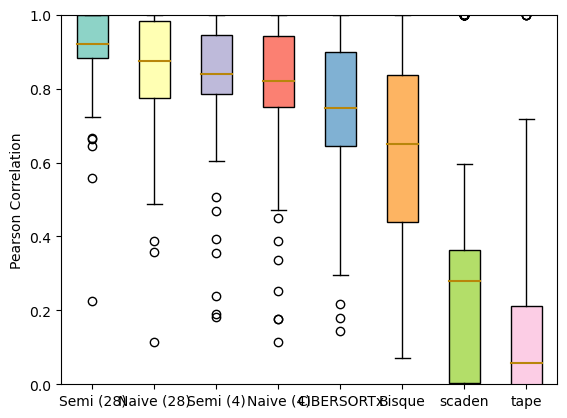

In [127]:
fig, ax = plt.subplots()
meanlineprops = dict(linestyle='-', linewidth=1.5, color='darkgoldenrod')

# Plot the boxplots
boxplot = ax.boxplot([pcors, naivecors, pcors4, naivecors4, cibercors, biscor,scadencors,tapecor], patch_artist=True,showmeans=True,meanline=True, meanprops=meanlineprops)
#,meanprops = dict(color = "green", linewidth = 1.5), showmeans=True,meanline=True)

# Define the colors for the boxes
box_colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']
box_colors = set3.colors
# Iterate over each box and set the facecolor
for box, color in zip(boxplot['boxes'], box_colors):
    box.set(facecolor=color)

for median in boxplot['medians']:
    median.set_color('none')  
    
# Add axis labels and title
#ax.set_xlabel('Method')
ax.set_ylabel('Pearson Correlation')
#ax.set_title('Deconvolution Performance Comparison')

# Add x-axis tick labels
ax.set_xticklabels(['Semi (28)', 'Naive (28)', 'Semi (4)', 'Naive (4)','CIBERSORTx','Bisque','scaden','tape'])
ax.set_ylim(0,1)
# Display the plot
plt.savefig('results/1111deconvpcor.pdf')
plt.show()


In [128]:
## wilcox for rmse

# between semi 4 patients and CIBERSORTx
r_semi4_ciber = wilcoxon(x=prmses4, y=ciberrmses, alternative='less')
print('between semi 4 and CIBERSORTx',r_semi4_ciber.statistic, r_semi4_ciber.pvalue)

# between semi 28 and naive 28
r_semi28_naive28 = wilcoxon(x=prmses, y=naivermse, alternative='less')
print('between semi 28 and naive 28',r_semi28_naive28.statistic, r_semi28_naive28.pvalue)

# between semi 4 and naivee 4
r_semi4_naive4 = wilcoxon(x=prmses4, y=naivermse4, alternative='less')
print('between semi 4 and naive 4',r_semi4_naive4.statistic, r_semi4_naive4.pvalue)

# between semi 28 and semi 4
r_semi28_semi4 = wilcoxon(x=prmses, y=prmses4, alternative='less')
print('between semi 28 and semi 4',r_semi28_semi4.statistic, r_semi28_semi4.pvalue)

# between semi 4 and bisque
r_semi4_bisque = wilcoxon(x=prmses4, y=bisrmse, alternative='less')
print('between semi 4 and bisque',r_semi4_bisque.statistic, r_semi4_bisque.pvalue)

# between semi 28 and sesmi 4
r_semi28_semi4 = wilcoxon(x=prmses, y=prmses4, alternative='less')
print('between semi 28 and semi 4',r_semi28_semi4.statistic, r_semi28_semi4.pvalue)

res = wilcoxon(x=prmses4, y=tapermse, alternative='less')
print('between semi 4 and tape',res.statistic, res.pvalue)

res = wilcoxon(x=prmses4, y=scadenrmses, alternative='less')
print('between semi 4 and scaden',res.statistic, res.pvalue)



between semi 4 and CIBERSORTx 2346.0 0.00038602172924439193
between semi 28 and naive 28 1174.0 1.2374601711804421e-05
between semi 4 and naive 4 3869.0 0.7343129189501648
between semi 28 and semi 4 846.0 1.539095436277561e-13
between semi 4 and bisque 771.0 3.51399235150409e-14
between semi 28 and semi 4 846.0 1.539095436277561e-13
between semi 4 and tape 771.0 3.51399235150409e-14
between semi 4 and scaden 1735.0 3.474976660353824e-07


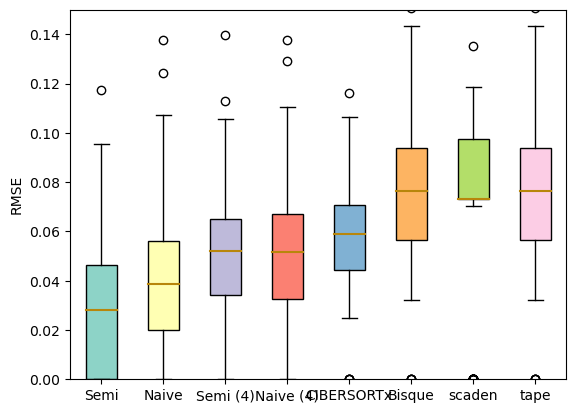

In [130]:
fig, ax = plt.subplots()

# Plot the boxplots
boxplot = ax.boxplot([prmses, naivermse, prmses4, naivermse4, ciberrmses, bisrmse,scadenrmses,tapermse], patch_artist=True,showmeans=True,meanline=True, meanprops=meanlineprops)

# Define the colors for the boxes
box_colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']
box_colors = set3.colors
# Iterate over each box and set the facecolor
for box, color in zip(boxplot['boxes'], box_colors):
    box.set(facecolor=color)

    
for median in boxplot['medians']:
    median.set_color('none')  
    
    
# Add axis labels and title
#ax.set_xlabel('Method')
ax.set_ylabel('RMSE')
#ax.set_title('Deconvolution Performance Comparison')

# Add x-axis tick labels
ax.set_xticklabels(['Semi', 'Naive', 'Semi (4)', 'Naive (4)','CIBERSORTx','Bisque','scaden','tape'])
ax.set_ylim(0,0.15)
# Display the plot
plt.savefig('results/1111deconv_rmse.pdf')

plt.show()